In [2]:
%autoreload 2

In [3]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pactools.grid_search import GridSearchCVProgressBar
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

In [4]:
fitness_df = utils.load_fitness_data()
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples.pddl']


,Index,src_file,game_name,domain_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,...,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4,real,original_game_name
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1.0,1.0,1.0,1.00,1.0,0.5,...,1,0,0,1,0,0,0,0,True,6172feb1665491d1efbce164-0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1.0,1.0,1.0,1.00,1.0,1.0,...,1,0,0,0,0,0,1,0,True,5f77754ba932fb2c4ba181d8-2
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1.0,1.0,1.0,0.00,1.0,0.0,...,0,0,0,0,1,0,0,0,True,614b603d4da88384282967a7-3
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1.0,1.0,1.0,0.00,1.0,1.0,...,0,0,0,1,0,0,0,0,True,5bc79f652885710001a0e82a-5
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1.0,1.0,1.0,0.25,1.0,1.0,...,0,0,0,0,0,1,0,0,True,614dec67f6eb129c3a77defd-6


In [5]:
def create_filtered_df(df: pd.DataFrame, 
    synthetic_data_src_files: typing.Sequence[str] = ('interactive-beta.pddl', 'ast-real-regrowth-samples.pddl'),
    ) -> pd.DataFrame:
    syntethic_df = fitness_df[fitness_df.src_file.isin(synthetic_data_src_files)].reset_index(drop=True)
    syntethic_df.loc[syntethic_df.src_file == synthetic_data_src_files[0], 'real'] = 1
    return syntethic_df

filtered_fitness_df = create_filtered_df(fitness_df)

In [6]:
filtered_fitness_df.head()

,Index,src_file,game_name,domain_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,...,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4,real,original_game_name
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1.0,1.0,1.0,1.00,1.0,0.5,...,1,0,0,1,0,0,0,0,1,6172feb1665491d1efbce164-0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1.0,1.0,1.0,1.00,1.0,1.0,...,1,0,0,0,0,0,1,0,1,5f77754ba932fb2c4ba181d8-2
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1.0,1.0,1.0,0.00,1.0,0.0,...,0,0,0,0,1,0,0,0,1,614b603d4da88384282967a7-3
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1.0,1.0,1.0,0.00,1.0,1.0,...,0,0,0,1,0,0,0,0,1,5bc79f652885710001a0e82a-5
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1.0,1.0,1.0,0.25,1.0,1.0,...,0,0,0,0,0,1,0,0,1,614dec67f6eb129c3a77defd-6


In [7]:
fake_games = filtered_fitness_df[filtered_fitness_df.src_file == 'ast-real-regrowth-samples.pddl'].reset_index()
broadcasted_original = filtered_fitness_df.loc[[filtered_fitness_df.index[(filtered_fitness_df.game_name == original_name)][0] for original_name in fake_games.original_game_name], :].reset_index()

original_regrown_diffs = (broadcasted_original.drop(NON_FEATURE_COLUMNS, axis=1) - fake_games.drop(NON_FEATURE_COLUMNS, axis=1))

unchanged_games_prop = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=1).sum() / len(original_regrown_diffs)
print(f'In {unchanged_games_prop * 100:.2f}% of the games, the regrown game was identical to the original game.')

In 4.89% of the games, the regrown game was identical to the original game.


In [16]:
never_change = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=0)
for x in never_change.index[never_change]:
    print(x)

correct_predicate_function_arity
section_without_pref_count_terminal
section_without_pref_count_scoring
arg_types_adjacent_agent_agent
arg_types_adjacent_any_object_blocks
arg_types_adjacent_any_object_colors
arg_types_adjacent_any_object_large_objects
arg_types_adjacent_any_object_ramps
arg_types_adjacent_any_object_small_objects
arg_types_adjacent_balls_building
arg_types_adjacent_blocks_any_object
arg_types_adjacent_colors_any_object
arg_types_adjacent_colors_building
arg_types_adjacent_colors_large_objects
arg_types_adjacent_colors_ramps
arg_types_adjacent_colors_room_features
arg_types_adjacent_furniture_colors
arg_types_adjacent_furniture_building
arg_types_adjacent_building_colors
arg_types_adjacent_building_large_objects
arg_types_adjacent_building_ramps
arg_types_adjacent_large_objects_agent
arg_types_adjacent_large_objects_any_object
arg_types_adjacent_large_objects_colors
arg_types_adjacent_large_objects_building
arg_types_adjacent_large_objects_ramps
arg_types_adjacent_ramp

In [7]:
original_df = filtered_fitness_df[filtered_fitness_df.src_file == 'interactive-beta.pddl'].reset_index(drop=True)
arr = np.array(original_df.all_variables_used) 
ind = np.where(arr != 1)[0]
print(ind)
original_df.iloc[ind, :]

[]


,Index,src_file,game_name,domain_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,no_adjacent_once,starts_and_ends_once,...,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4,real,original_game_name


# Synthetic model-fitting experiment approach
We have a large dataset now, I can try to cross-validate over some of the choices I might make:
* Loss function
* Parameters of each loss function (margin, etc.)
* Batch size
* Number of negative examples sampled per iteration
* Regularization strength?
* ...?



In [8]:
def cross_validate(train: pd.DataFrame, feature_columns: typing.List[str],
    param_grid: typing.Union[typing.List[typing.Dict[str, typing.Any]], typing.Dict[str, typing.Any]],
    scoring_function: typing.Callable = utils.evaluate_fitness,
    model_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    train_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None, 
    cv_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    n_folds: int = 5, verbose: int = 0):

    if model_kwargs is None:
        model_kwargs = {}

    if train_kwargs is None:
        train_kwargs = {}

    if cv_kwargs is None:
        cv_kwargs = {}

    if 'n_jobs' not in cv_kwargs: 
        cv_kwargs['n_jobs'] = -1
    if 'verbose' not in cv_kwargs:
        cv_kwargs['verbose'] = verbose

    train_tensor = utils.df_to_tensor(train, feature_columns)
    pipeline = Pipeline(steps=[('scaler', utils.CustomSklearnScaler()), ('fitness', utils.SklearnFitnessWrapper(model_kwargs=model_kwargs, train_kwargs=train_kwargs))])

    if isinstance(param_grid, list):
        for param_grid_dict in param_grid:
            param_grid_dict['fitness__n_features'] = [len(feature_columns)]
    else:
        param_grid['fitness__n_features'] = [len(feature_columns)]        

    random_seed = train_kwargs['random_seed'] if 'random_seed' in train_kwargs else None

    cv = GridSearchCVProgressBar(pipeline, param_grid, scoring=scoring_function, 
        cv=KFold(n_folds, shuffle=True, random_state=random_seed), 
        **cv_kwargs)
    return cv.fit(train_tensor, None)


def model_fitting_experiment(df: pd.DataFrame,
    param_grid: typing.Union[typing.List[typing.Dict[str, typing.Any]], typing.Dict[str, typing.Any]], 
    feature_columns: typing.Optional[typing.List[str]] = None, 
    random_seed: int = utils.DEFAULT_RANDOM_SEED,
    scoring_function: typing.Callable = utils.evaluate_fitness,
    model_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    train_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    cv_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    n_folds: int = 5, verbose: int = 0
    ):

    if model_kwargs is None:
        model_kwargs = {}

    if train_kwargs is None:
        train_kwargs = {}

    filtered_df = create_filtered_df(df)

    if feature_columns is None:
        feature_columns = [c for c in filtered_df.columns if c not in NON_FEATURE_COLUMNS]

    # rng = np.random.default_rng(random_seed)

    # train_df, test_df = utils.train_test_split_by_game_name(filtered_df, random_seed=random_seed)
    cv = cross_validate(filtered_df, feature_columns, param_grid, 
        scoring_function=scoring_function,
        train_kwargs={'random_seed': random_seed, **train_kwargs}, 
        model_kwargs=model_kwargs, cv_kwargs=cv_kwargs, n_folds=n_folds, verbose=verbose)
    # best_model = cv.best_estimator_.named_steps['fitness'].model  # type: ignore

    # TODO: add evaluation on the held-out part of the dataset here
    return cv, None



In [12]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
    # {
    # #     'fitness__loss_function': [utils.fitness_log_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # # },
    # # {
    # #     'fitness__loss_function': [utils.fitness_square_square_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__margin': [1, 2, 4],
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # },
    
]

all_feature_columns = [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict()
cv_kwargs = dict(refit='single_game_rank')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv, test_df = model_fitting_experiment(fitness_df, test_param_grid,
    scoring_function=scoring, verbose=1, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)


Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


In [13]:
cv_df = pd.concat([
    pd.DataFrame(cv.cv_results_["params"]), 
    pd.DataFrame(cv.cv_results_["mean_test_overall_ecdf"], columns=['ecdf_mean']), 
    pd.DataFrame(cv.cv_results_["std_test_overall_ecdf"], columns=['ecdf_std']), 
    pd.DataFrame(cv.cv_results_["rank_test_overall_ecdf"], columns=['ecdf_rank']),
    pd.DataFrame(cv.cv_results_["mean_test_single_game_rank"], columns=['game_rank_mean']), 
    pd.DataFrame(cv.cv_results_["std_test_single_game_rank"], columns=['game_rank_std']), 
    pd.DataFrame(cv.cv_results_["rank_test_single_game_rank"], columns=['game_rank_rank']),
],axis=1)

cv_df.sort_values(by='ecdf_rank').head(10)

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
515,4,32,<function fitness_hinge_loss at 0x160ff4f70>,0.100,1,835,2.00,-0.355517,0.020657,1,0.867599,0.015660,1001
1212,16,32,<function fitness_hinge_loss at 0x160ff4f70>,0.003,8,835,0.00,-0.356755,0.030363,2,0.861003,0.008027,1098
1149,16,16,<function fitness_hinge_loss at 0x160ff4f70>,0.003,8,835,0.25,-0.357387,0.034409,3,0.857911,0.014713,1131
1146,16,16,<function fitness_hinge_loss at 0x160ff4f70>,0.003,4,835,1.00,-0.357509,0.034478,4,0.864613,0.017536,1062
379,4,4,<function fitness_hinge_loss at 0x160ff4f70>,0.003,4,835,2.00,-0.357560,0.032387,5,0.874597,0.014576,771
827,8,16,<function fitness_hinge_loss at 0x160ff4f70>,0.003,4,835,2.00,-0.357561,0.030613,6,0.877171,0.014919,597
562,4,32,<function fitness_hinge_loss at 0x160ff4f70>,0.003,1,835,1.00,-0.358438,0.041520,7,0.870099,0.027692,948
1150,16,16,<function fitness_hinge_loss at 0x160ff4f70>,0.003,8,835,1.00,-0.358450,0.027920,8,0.857969,0.013398,1130
572,4,32,<function fitness_hinge_loss at 0x160ff4f70>,0.003,8,835,0.00,-0.358801,0.032481,9,0.878396,0.011925,470
263,2,64,<function fitness_hinge_loss at 0x160ff4f70>,0.100,2,835,2.00,-0.358804,0.039774,10,0.867360,0.014239,1009


In [14]:
cv_df.sort_values(by='game_rank_rank').head(10)

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
76,2,8,<function fitness_hinge_loss at 0x160ff4f70>,0.10,8,835,0.00,-0.375864,0.018862,1064,0.884967,0.011271,1
332,4,4,<function fitness_hinge_loss at 0x160ff4f70>,0.10,8,835,0.00,-0.374231,0.021605,999,0.884515,0.014310,2
92,2,8,<function fitness_hinge_loss at 0x160ff4f70>,0.03,8,835,0.00,-0.372435,0.024427,894,0.883660,0.012760,3
328,4,4,<function fitness_hinge_loss at 0x160ff4f70>,0.10,4,835,0.00,-0.377231,0.022387,1130,0.883577,0.011699,4
1260,16,64,<function fitness_hinge_loss at 0x160ff4f70>,0.01,8,835,0.00,-0.363644,0.031134,283,0.883438,0.010854,5
666,8,4,<function fitness_hinge_loss at 0x160ff4f70>,0.03,4,835,1.00,-0.363648,0.032347,284,0.883207,0.015958,6
406,4,8,<function fitness_hinge_loss at 0x160ff4f70>,0.03,2,835,1.00,-0.365672,0.032172,433,0.883067,0.014880,7
389,4,8,<function fitness_hinge_loss at 0x160ff4f70>,0.10,2,835,0.25,-0.369282,0.031147,682,0.883043,0.014926,8
1102,16,16,<function fitness_hinge_loss at 0x160ff4f70>,0.10,8,835,1.00,-0.363406,0.030405,260,0.882977,0.011788,9
1094,16,16,<function fitness_hinge_loss at 0x160ff4f70>,0.10,2,835,1.00,-0.369309,0.028058,684,0.882911,0.011918,10


In [15]:
filtered_df = create_filtered_df(fitness_df)
feature_columns = [c for c in filtered_df.columns if c not in NON_FEATURE_COLUMNS]
full_tensor = utils.df_to_tensor(filtered_df, feature_columns)

cv.best_estimator_.fit(full_tensor)

output_path = '../models/cv_fitness_model_2022_01_09.pkl.gz'
original_output_path = output_path[:]
i = 0
while os.path.exists(output_path):
    output_path = original_output_path + f'_{i}'
    i += 1

with gzip.open(output_path, 'wb') as f:
    pickle.dump(cv.best_estimator_, f, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
# DEFAULT_FITNESS_FUNCTION_PATH = '../models/cv_fitness_model_2022_12_23.pkl.gz'
# with gzip.open(DEFAULT_FITNESS_FUNCTION_PATH, 'rb') as f:
#     cv_fitness_model = pickle.load(f)

cv_fitness_model = cv.best_estimator_

In [17]:
real_scores = cv_fitness_model.transform(full_tensor[:, 0, :]).detach().squeeze().numpy()
negative_scores = cv_fitness_model.transform(full_tensor[:, 1:, :]).detach().squeeze().numpy()
real_scores.mean(), real_scores.std()

(-20.34876, 10.85202)

Text(0, 0.5, 'Count')

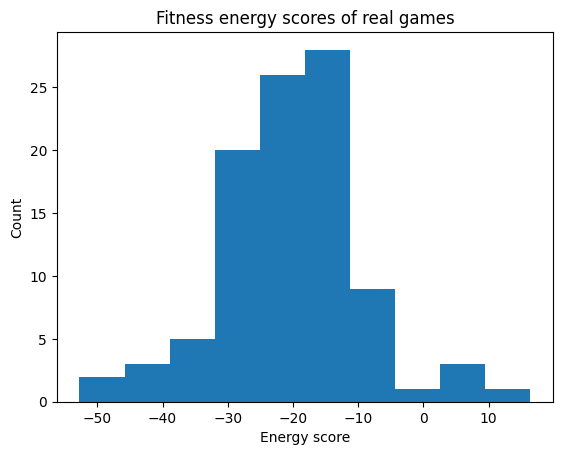

In [18]:
plt.hist(real_scores)
plt.title('Fitness energy scores of real games')
plt.xlabel('Energy score')
plt.ylabel('Count')

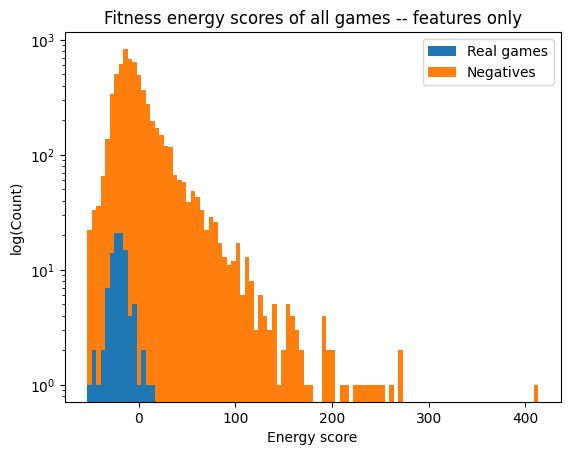

In [20]:

plt.hist([real_scores, negative_scores.flatten()], stacked=True, bins=100,
    label=['Real games', 'Negatives'])
plt.title('Fitness energy scores of all games -- features only')
plt.xlabel('Energy score')
plt.ylabel('log(Count)')
plt.semilogy()
plt.legend(loc='best')

In [ ]:
weights = cv.best_estimator_.named_steps['fitness'].model.fc1.weight.data.detach().numpy().squeeze()
bias = cv.best_estimator_.named_steps['fitness'].model.fc1.bias.data.detach().numpy().squeeze()
weights.mean(), weights.std(), bias

In [ ]:
plt.hist(weights, bins=100)
plt.title('Fitness Model Weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')

In [ ]:
n_top = 10
sorted_indices = np.argsort(weights)
top_weight_indices = sorted_indices[-n_top:]
bottom_weight_indices = sorted_indices[:n_top]

top_features = [feature_columns[i] for i in top_weight_indices][::-1]
bottom_features = [feature_columns[i] for i in bottom_weight_indices]

In [ ]:
bottom_features

In [ ]:
top_features

In [ ]:
syntethic_fitness_df = create_filtered_df(fitness_df)
feature_columns = [c for c in syntethic_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
train_df, test_df = utils.train_test_split_by_game_name(syntethic_fitness_df, random_seed=42)
train_df, val_df = utils.train_test_split_by_game_name(train_df, random_seed=42)
train_tensor = utils.df_to_tensor(train_df, feature_columns)
val_tensor = utils.df_to_tensor(val_df, feature_columns)
test_tensor = utils.df_to_tensor(test_df, feature_columns)

scaler = utils.CustomSklearnScaler().fit(train_tensor)
train_tensor = scaler.transform(train_tensor)
val_tensor = scaler.transform(val_tensor)
test_tensor = scaler.transform(test_tensor)

model = utils.FitnessEenrgyModel(train_tensor.shape[-1], output_activation=nn.Identity())
model.apply(utils.init_weights)
results = utils.train_and_validate_model(
    model, train_tensor, val_tensor,
    loss_function=utils.fitness_hinge_loss,  
    loss_function_kwargs=dict(margin=4.0),
    lr=1e-2, weight_decay=0.0,
    batch_size=1, k=32,
    patience_epochs=10,
    random_seed=42,
    eval_method=utils.evaluate_fitness_flipped_sign,
)

In [ ]:
scores = model(val_tensor)
pos = scores[:, 0, None]
neg = scores[:, 1:]
pos.shape, neg.shape

In [ ]:
margin = 1
torch.relu(pos + margin - neg).shape

In [ ]:
utils.fitness_hinge_loss_with_cross_example(scores)

In [ ]:
scoring(model, train_tensor), scoring(model, val_tensor), scoring(model, test_tensor)

In [ ]:
train_preds = model(train_tensor).detach().squeeze().numpy()
val_preds = model(val_tensor).detach().squeeze().numpy()
test_preds = model(test_tensor).detach().squeeze().numpy()

In [ ]:
((train_preds[:, 0, None] < train_preds[:, 1:]).sum(axis=1) / (train_preds.shape[1] - 1)).mean()

In [ ]:
def _make_labels(prds: np.ndarray):
    labels = np.zeros_like(prds)
    labels[:, 0] = 1
    return labels

train_labels = _make_labels(train_preds)
val_labels = _make_labels(val_preds)
test_labels = _make_labels(test_preds)


In [ ]:
from sklearn import metrics


def predict_at_threshold(preds: np.ndarray, threshold: float):
    y_pred = (preds < threshold).astype(int)
    y_true = np.zeros_like(y_pred)
    y_true[:, 0] = 1
    return y_true.reshape(-1), y_pred.reshape(-1)


def evaluate_f1_with_threshold(preds: np.ndarray, threshold: float):
    return metrics.f1_score(*predict_at_threshold(preds, threshold))


def find_f1_threshold(preds: np.ndarray):
    best_f1 = 0
    best_threshold = 0
    for threshold in np.linspace(preds.min(), preds.max(), 100):
        f1 = evaluate_f1_with_threshold(preds, threshold)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1


train_threshold, train_f1 = find_f1_threshold(train_preds)
evaluate_f1_with_threshold(test_preds, train_threshold)

In [ ]:
metrics.PrecisionRecallDisplay.from_predictions(train_labels.reshape(-1), train_preds.reshape(-1))

In [ ]:
(train_preds[:, 0, np.newaxis] <= train_preds[:, 1:]).sum(axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(train_preds[:, 1:].reshape(-1), bins=100, label='negatives')
ax.hist(train_preds[:, 0], bins=100, label='positives')
ax.legend()
plt.show()

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF

In [ ]:
train_ecdf = ECDF(train_preds.reshape(-1))

In [ ]:
train_ecdf(train_preds[:, 0]).mean()

In [ ]:
t = torch.tensor(train_preds)

In [ ]:
p = t[:, 0]
n = t[:, 1:]

(p[:, None] < n).mean(axis=1, dtype=torch.float)

In [9]:
filtered_df = create_filtered_df(fitness_df)
feature_columns = [c for c in filtered_df.columns if c not in NON_FEATURE_COLUMNS]
full_tensor = utils.df_to_tensor(filtered_df, feature_columns)
full_tensor.shape

torch.Size([98, 65, 835])

In [11]:
torch.save(full_tensor, '../data/interactive-beta-and-regrowth-fitness-features-2023-01-09.pt', pickle_protocol=pickle.HIGHEST_PROTOCOL)